In [7]:
!pip install -U imbalanced-learn

import os
import shutil
import pathlib
import PIL
import cv2
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import random
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow .keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from PIL import Image, UnidentifiedImageError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


print("All done")

All done


## A- Files to Lists

In [8]:
Path_data = '/kaggle/input/diabetic-retinopathy-dataset'
data = os.listdir(Path_data)
Healthy = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Healthy')
Mild = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Mild DR')
Moderate = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Moderate DR')
Proliferate = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Proliferate DR')
Severe = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Severe DR')

In [9]:
print("classes names :", (data), "\n______________________________\n")
print("Number of classes :", len(data), "\n______________________________\n")
print("Number of Healty images :", len(Healthy), "\n______________________________\n")
print("Number of Mild images :", len(Mild),  "\n______________________________\n")
print("Number of Moderate images :", len(Moderate),  "\n______________________________\n")
print("Number of Proliferate images :", len(Proliferate),  "\n______________________________\n")
print("Number of severe images :", len(Severe),  "\n______________________________\n")

classes names : ['Severe DR', 'Healthy', 'Moderate DR', 'Mild DR', 'Proliferate DR'] 
______________________________

Number of classes : 5 
______________________________

Number of Healty images : 1000 
______________________________

Number of Mild images : 370 
______________________________

Number of Moderate images : 900 
______________________________

Number of Proliferate images : 290 
______________________________

Number of severe images : 190 
______________________________



### As noticed above: Imbalanced Data

## B- Create Dataframe

In [10]:
Path_data = '/kaggle/input/diabetic-retinopathy-dataset'

imgpaths = []
labels =[]
data = os.listdir(Path_data)

for i in data:
    classpath = os.path.join(Path_data, i)
    imglist = os.listdir(classpath)
    
    for img in imglist:
        imgpath = os.path.join(classpath, img)
        
        imgpaths.append(imgpath)
        labels.append(i)

Paths = pd.Series(imgpaths, name = 'Paths')
Labels = pd.Series(labels, name = 'Labels')

Df= pd.concat([Paths, Labels], axis = 1)
Df.head(5)

,Paths,Labels
0,/kaggle/input/diabetic-retinopathy-dataset/Sev...,Severe DR
1,/kaggle/input/diabetic-retinopathy-dataset/Sev...,Severe DR
2,/kaggle/input/diabetic-retinopathy-dataset/Sev...,Severe DR
3,/kaggle/input/diabetic-retinopathy-dataset/Sev...,Severe DR
4,/kaggle/input/diabetic-retinopathy-dataset/Sev...,Severe DR


# Data Preprocessing

## A- Random Over sampling

more preferred with text data not with images

In [12]:
X= Df.drop(['Labels'], axis = 1)
y = Df['Labels']
y.value_counts()

Labels
Healthy           1000
Moderate DR        900
Mild DR            370
Proliferate DR     290
Severe DR          190
Name: count, dtype: int64

## B- Split data into train, valid, test

In [13]:
train, testval = train_test_split(Df, test_size = 0.2, shuffle = True, random_state = 123)
valid, test = train_test_split(testval, test_size = 0.5, shuffle = True, random_state = 123)

print("Train shape: ", train.shape)
print("Valid shape: ", valid.shape)
print("Test shape: ",test.shape)

train.Labels.value_counts()

Train shape:  (2200, 2)
Valid shape:  (275, 2)
Test shape:  (275, 2)


Labels
Healthy           796
Moderate DR       724
Mild DR           290
Proliferate DR    236
Severe DR         154
Name: count, dtype: int64

## C- Data Augmentation

In [14]:
batch_size = 20   
img_size = (224, 224) 
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_G = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30.,
    fill_mode='nearest',
    )

V_G = ImageDataGenerator()

t_G = ImageDataGenerator()

Train = tr_G.flow_from_dataframe(train, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Valid = V_G.flow_from_dataframe(valid, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Test = t_G.flow_from_dataframe(test, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 2200 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.


## D- Represent a sample

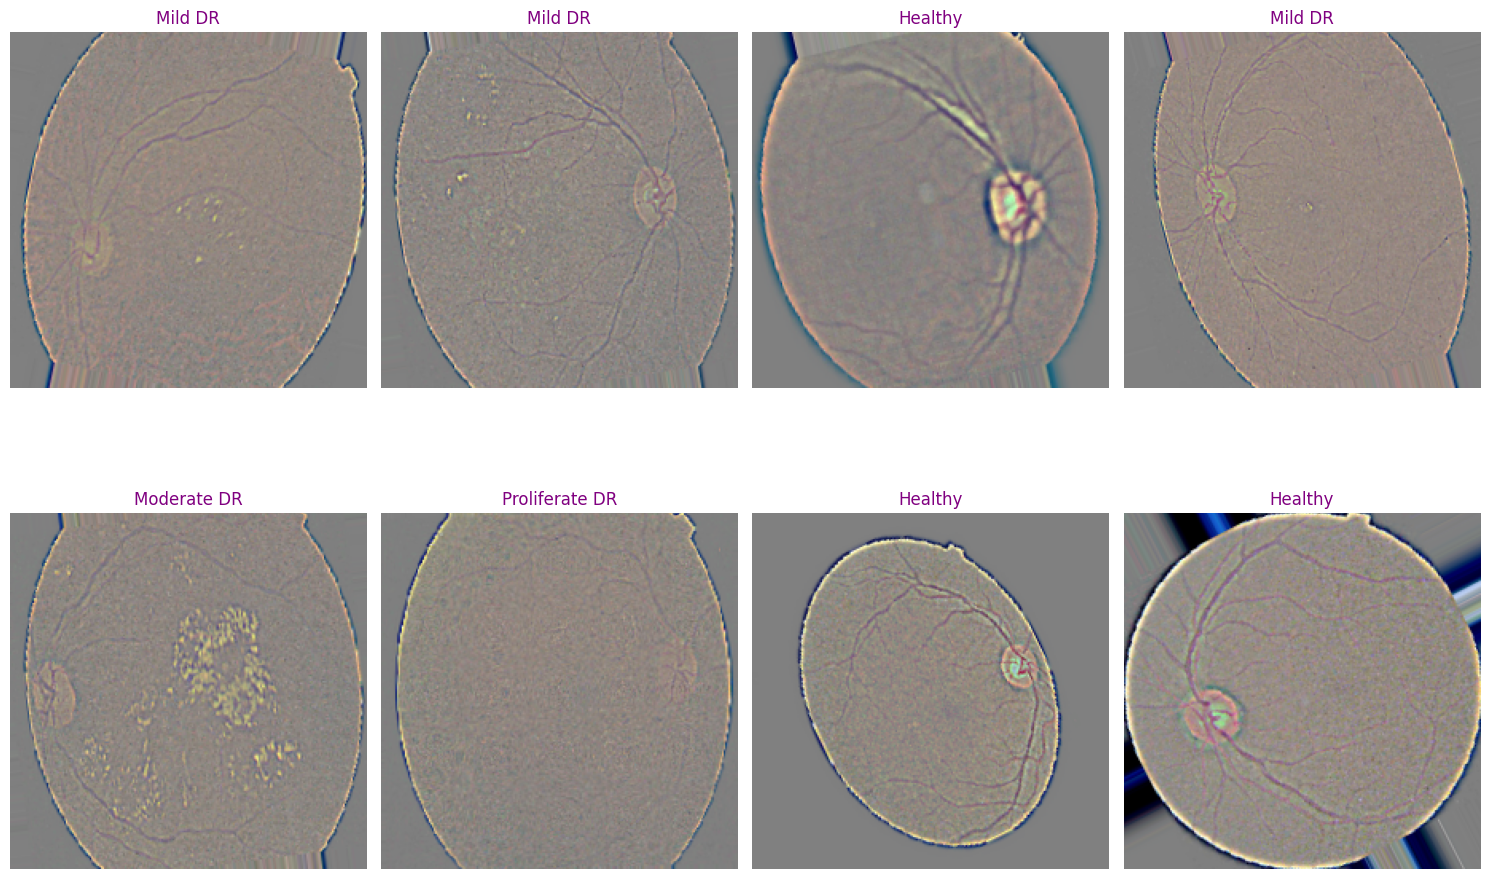

In [15]:
L_index = Train.class_indices
L_index
Keys = list(L_index.keys())
Keys
imgs, labels = next(Train)

plt.figure(figsize= (15, 15))

for i in range(8):
    plt.subplot(3, 4, i +1)
    im = imgs[i]/255
    plt.imshow(im)
    
    index = np.argmax(labels[i])
    label = Keys[index]
    plt.title(label, color = 'purple')
    plt.axis('off')
    
plt.tight_layout()    
plt.show()


# Modelling

## A- Create a model using transfer learning with EfficientNetB2


In [18]:
n_classes = len(list(Train.class_indices.keys()))
n_classes

img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model= EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 

base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.999, epsilon=0.001 )(x)
x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.2, seed=123)(x)
x = Dense(512, kernel_regularizer = regularizers.l2(l = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)
output=Dense(n_classes, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.0001 



In [19]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='elu'))
model.add(Dense(256, activation='elu'))
model.add(Dense(128, activation = 'elu'))
model.add(Dense(5, activation='softmax'))


In [20]:
model.compile(
    Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 dropout_9 (Dropout)         (None, 1536)              0         
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               786944    
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                                 
 dense_14 (Dense)            (None, 128)               32896     
                                                        

## B- Visualize model layers

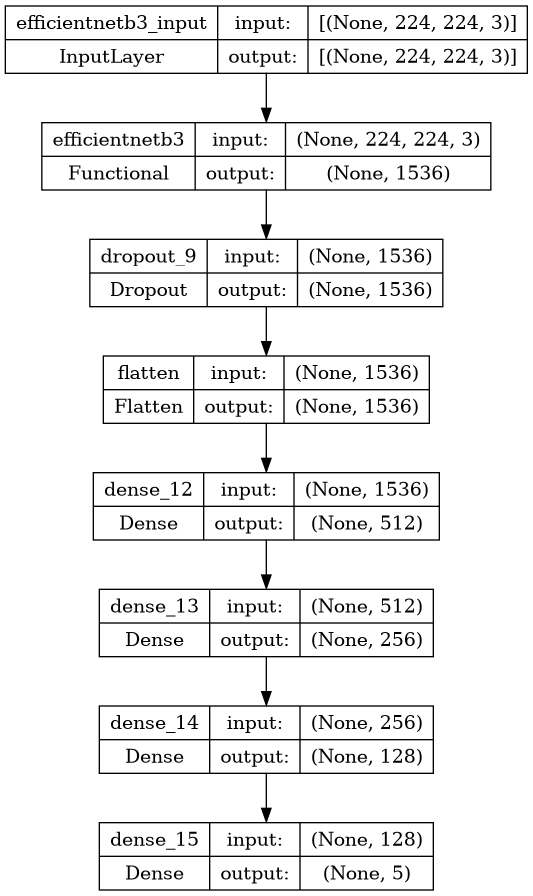

In [22]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

## C- Training phase

In [23]:
epochs = 50
history = model.fit(x= Train, epochs= epochs, verbose= 1, validation_data= Valid, validation_steps= None, shuffle= False)

Epoch 1/50


2024-06-24 05:52:25.345311: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


110/110 [==============================] - 101s 386ms/step - loss: 1.6518 - acc: 0.4814 - val_loss: 1.3992 - val_acc: 0.4982
Epoch 2/50
110/110 [==============================] - 36s 321ms/step - loss: 1.2277 - acc: 0.5736 - val_loss: 1.0855 - val_acc: 0.5564
Epoch 3/50
110/110 [==============================] - 36s 325ms/step - loss: 1.1103 - acc: 0.5959 - val_loss: 0.9009 - val_acc: 0.6436
Epoch 4/50
110/110 [==============================] - 36s 324ms/step - loss: 1.0066 - acc: 0.6214 - val_loss: 0.8351 - val_acc: 0.6800
Epoch 5/50
110/110 [==============================] - 36s 324ms/step - loss: 0.9335 - acc: 0.6495 - val_loss: 0.7940 - val_acc: 0.6836
Epoch 6/50
110/110 [==============================] - 36s 326ms/step - loss: 0.8878 - acc: 0.6659 - val_loss: 0.8124 - val_acc: 0.6618
Epoch 7/50
110/110 [==============================] - 36s 323ms/step - loss: 0.8454 - acc: 0.6759 - val_loss: 0.7667 - val_acc: 0.6982
Epoch 8/50
110/110 [==============================] - 36s 323ms/s

## D- Evaluation 

In [24]:
tr_acc = history.history['acc']
tr_loss = history.history['loss']

v_acc = history.history['val_acc']
v_loss = history.history['val_loss']

index_acc = np.argmax(v_acc)
high_Vacc = v_acc[index_acc]

index_loss = np.argmin(v_loss)
low_Vloss = v_loss[index_loss]

Epochs =[]
for i in range(len(tr_acc)):
    Epochs.append (i+1)

best_acc = f'Best epoch ={str(index_acc +1)}'
best_loss = f'Best epoch ={str(index_loss+1)}'

## E- Let's Visualize it

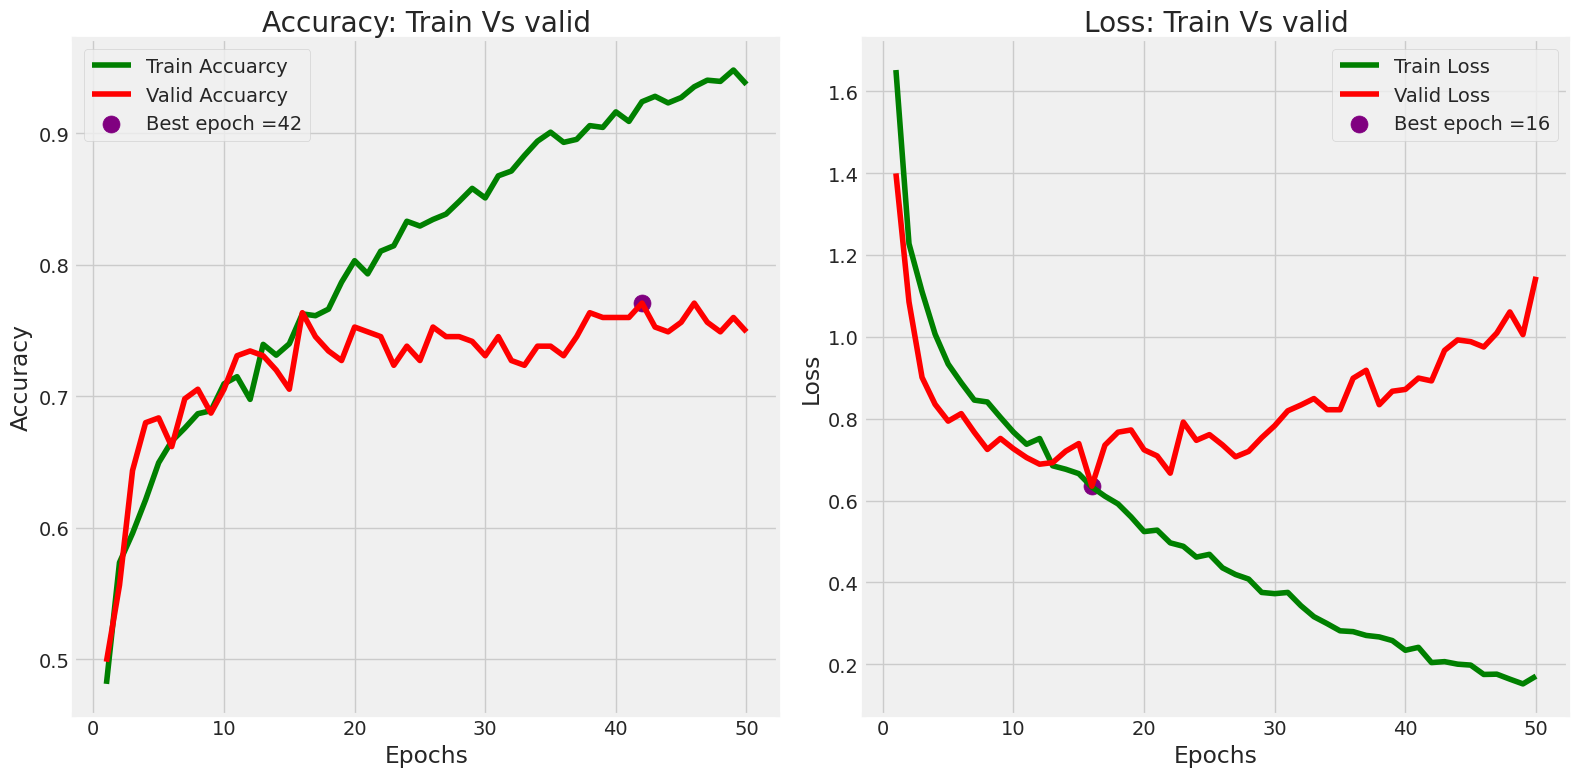

In [25]:
plt.figure(figsize = (16, 8))
plt.style.use('fivethirtyeight')


plt.subplot(1,2,1)
plt.plot(Epochs, tr_acc, "g", label = "Train Accuarcy")
plt.plot(Epochs, v_acc, "r", label = "Valid Accuarcy")
plt.scatter(index_acc+1, high_Vacc, s= 150, color = 'purple', label = best_acc)

plt.title("Accuracy: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(Epochs, tr_loss, "g", label = "Train Loss")
plt.plot(Epochs, v_loss, "r", label = "Valid Loss")
plt.scatter(index_loss+1, low_Vloss, s= 150, color = 'purple', label = best_loss)

plt.title("Loss: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
Train_sc = model.evaluate(Train, verbose = 1)
Valid_sc = model.evaluate(Valid, verbose = 1)
Test_sc =model.evaluate(Test, verbose = 1)

print('Train Scores : \n    accuracy:', Train_sc[1], '\n      Loss: ', Train_sc[0], '\n________________________')
print('Valid Scores : \n    accuracy:', Valid_sc[1], '\n      Loss: ', Valid_sc[0], '\n________________________')
print('Test Scores : \n    accuracy:', Test_sc[1], '\n      Loss: ', Test_sc[0], '\n________________________')

14/14 [==============================] - 2s 161ms/step - loss: 1.0371 - acc: 0.7600
Train Scores : 
    accuracy: 0.9854545593261719 
      Loss:  0.04501418024301529 
________________________
Valid Scores : 
    accuracy: 0.7490909099578857 
      Loss:  1.1467361450195312 
________________________
Test Scores : 
    accuracy: 0.7599999904632568 
      Loss:  1.0370627641677856 
________________________


# 5 Get  predictions

In [27]:
predictions = model.predict_generator(Test)
y_pred = np.argmax(predictions, axis = 1)

print(predictions)
print(y_pred)

[[9.9999881e-01 1.2425154e-06 3.2247904e-09 3.1400340e-09 1.1022807e-13]
 [9.9999964e-01 3.8657126e-07 6.5387244e-12 7.0915436e-13 5.0149839e-15]
 [2.6647876e-06 9.6966680e-03 9.8952579e-01 1.0155239e-04 6.7331200e-04]
 ...
 [5.2188589e-05 8.4084415e-01 1.5010668e-01 8.9842118e-03 1.2689036e-05]
 [9.9979645e-01 2.0213495e-04 1.2294668e-06 2.5051989e-07 2.8388104e-11]
 [3.5629699e-09 1.1052624e-06 9.9997485e-01 5.5610599e-07 2.3530332e-05]]
[0 0 2 1 2 0 2 1 0 1 1 0 0 2 1 1 1 1 1 0 0 0 0 2 1 1 1 2 1 2 2 0 0 3 0 1 2
 2 2 2 0 3 2 1 2 1 0 2 0 2 1 1 2 2 1 0 2 0 2 2 0 2 1 2 0 1 1 0 0 2 0 2 0 0
 1 2 2 1 0 0 2 1 2 2 0 1 0 3 1 1 2 1 2 1 0 1 3 2 1 2 1 1 4 2 0 0 0 2 1 2 4
 0 3 2 0 2 0 4 2 1 0 3 0 1 1 3 1 0 0 2 0 1 0 1 2 2 2 0 2 1 0 0 0 0 0 0 0 0
 0 2 0 0 0 0 1 0 0 2 1 2 2 0 2 2 1 4 0 0 1 0 2 0 4 2 1 3 0 0 0 2 2 1 1 2 0
 2 0 2 2 1 1 0 2 0 0 3 2 2 1 1 1 1 0 2 0 4 1 2 2 0 1 0 2 2 0 0 1 0 1 0 2 2
 2 2 2 2 2 2 4 0 2 0 0 0 0 2 0 0 1 2 0 0 2 2 0 3 0 0 1 0 0 1 2 1 0 0 0 0 1
 2 2 1 2 4 2 1 2 4 0 0 1 2 1 0 

In [28]:
Test_cl_ind = Test.class_indices
classes = list(Test_cl_ind.keys())
cm = confusion_matrix(Test.classes, y_pred)
cm

array([[97,  2,  0,  0,  0],
       [ 3, 38,  5,  0,  0],
       [ 0, 21, 63,  2,  4],
       [ 0,  5, 11,  6,  0],
       [ 0,  2,  9,  2,  5]])

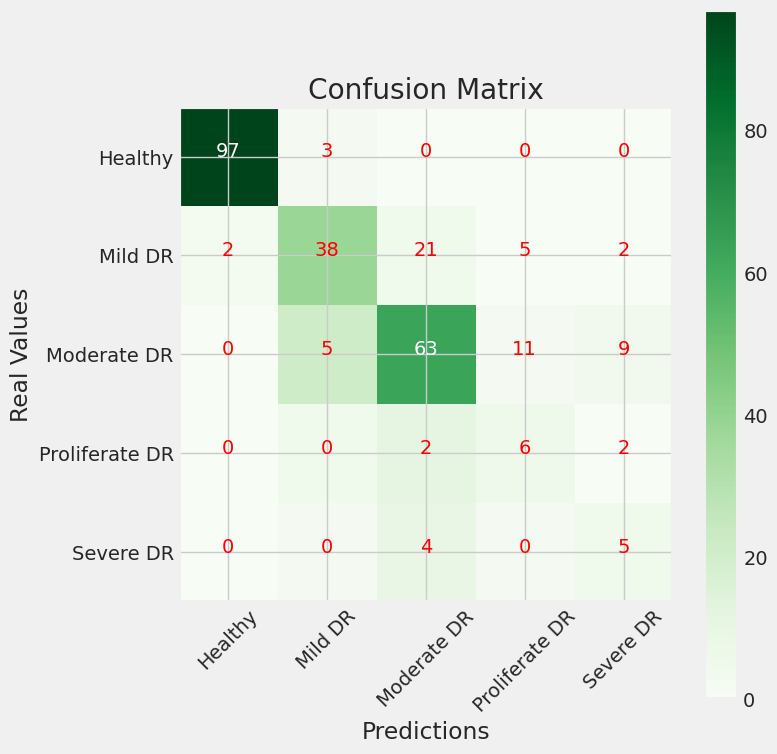

In [29]:
plt.figure(figsize =(8, 8))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,rotation = 45)
plt.yticks(tick_marks, classes)

thresh = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(i, j, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i,j] > thresh  else 'red')
    
plt.tight_layout()
plt.xlabel('Predictions')
plt.ylabel('Real Values')
plt.show()

In [30]:
print(classification_report(Test.classes, y_pred, target_names = classes))


                precision    recall  f1-score   support

       Healthy       0.97      0.98      0.97        99
       Mild DR       0.56      0.83      0.67        46
   Moderate DR       0.72      0.70      0.71        90
Proliferate DR       0.60      0.27      0.37        22
     Severe DR       0.56      0.28      0.37        18

      accuracy                           0.76       275
     macro avg       0.68      0.61      0.62       275
  weighted avg       0.76      0.76      0.75       275

